# 16 OpenCV DNN - Part 2
.
- OCR using **OpenCV Find Contour** + **Google Tesseract**
- OCR using **OpenCV DNN (EAST Model)** + **Google Tesseract**
- OCR using **OpenCV DNN (Yolo Model)** + **Google Tesseract**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
cv2.__version__

'4.5.0'

# *Reading text in the wild*
- Any Typical machine learning OCR pipeline follows the following steps

![](resource/RTD.png)

- Image Processing :
    - crop & resize
    - binaryzation
    - noise removal
- Text Detection :
    - using `cv2.findContour()` with specified contour property.
    - using `cv2.dnn` with **EAST model** (Efficient accurate scene text detector) 
- Text Recognition :
    - using **Google Tesseract**
    - using `cv2.ml` with **SVM algorithm** (support vector machine) 

### EAST (Efficient accurate scene text detector)
- Research paper : https://arxiv.org/abs/1704.03155
- This is a very robust deep learning method for text detection based on this paper. 
- It is worth mentioning as it is only a text detection method. 
- It can find horizontal and rotated bounding boxes. 
- It can be used in combination with any text recognition method.
- EAST runs near real-time at **13FPS** on **720p** images with high text detection accuracy. 
- Implementation is available in **OpenCV 3.4.2** and **OpenCV 4** via **OpenCV DNN**. 
- EAST Model pretrained in Tensorflow protobuf format.
- **Download model** from : https://github.com/ApexPredator1/EAST-text-detection-OpenCV/blob/master/frozen_east_text_detection.pb

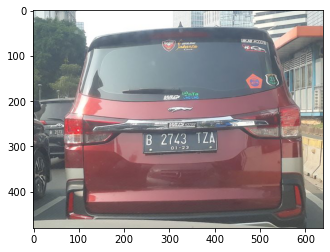

In [40]:
img = cv2.imread("cars_1/plat-nomor-3.jpg")

plt.imshow(img[:,:,::-1])

In [41]:
inpWidth = 416      # Width of network's input image
inpHeight = 416     # Height of network's input image

# resize image 
img = cv2.resize(img, (inpHeight, inpWidth))

# construct a blob from the image to forward pass it to EAST model
blob = cv2.dnn.blobFromImage(img, 1.0, (inpWidth, inpHeight),
	(0, 0, 0), swapRB=True, crop=False)

`cv2.dnn.blobFromImage(img,scalefactor = 1.0,output_size, mean_channel,swapRB = false,crop = false,ddepth = cv2.CV_32F)`

- `image`	input image (with 1-, 3- or 4-channels).
- `size`	spatial size for output image
- `mean`	scalar with mean values which are subtracted from channels. Values are intended to be in (mean-R, mean-G, mean-B) order if image has BGR ordering and swapRB is true.
- `scalefactor`	multiplier for image values.
- `swapRB`	flag which indicates that swap first and last channels in 3-channel image is necessary.
- `crop`	flag which indicates whether image will be cropped after resize or not
- `ddepth`	Depth of output blob. Choose cv2.CV_32F or cv2.CV_8U.

In [4]:
img.shape, blob.shape

((416, 416, 3), (1, 3, 416, 416))

In [42]:
# read EAST model

east_model = "tensorflow/frozen_east_text_detection.pb"
net = cv2.dnn.readNet(east_model)

- `cv2.dnn.readNet(model, configration)` 
- where :
    - `model` :
        - `*.caffemodel` (Caffe, http://caffe.berkeleyvision.org/)
        - `*.pb` (TensorFlow, https://www.tensorflow.org/)
        - `*.t7` | `*.net` (Torch, http://torch.ch/)
        - `*.weights` (Darknet, https://pjreddie.com/darknet/)
        - `*.bin` (DLDT, https://software.intel.com/openvino-toolkit)
    - `configuration` :
        - `*.prototxt` (Caffe, http://caffe.berkeleyvision.org/)
        - `*.pbtxt` (TensorFlow, https://www.tensorflow.org/)
        - `*.cfg` (Darknet, https://pjreddie.com/darknet/)
        - `*.xml` (DLDT, https://software.intel.com/openvino-toolkit)
- This function automatically detects an origin framework of trained model and calls an appropriate function such 
    - `cv2.dnn.readNetFromCaffe` 
    - `cv2.dnn.readNetFromTensorflow`
    - `cv2.dnn.readNetFromTorch` 
    - `cv2.dnn.readNetFromDarknet`

In [43]:
# set backend & target OpenCV DNN

net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

- Get Output layer using `.getUnconnectedOutLayersNames()` from `net` object

In [44]:
layerOutput = net.getUnconnectedOutLayersNames()

In [45]:
layerOutput

['feature_fusion/concat_3', 'feature_fusion/Conv_7/Sigmoid']

- Set blob to input network using `.setInput()` on `net` object
- Do forward pass and get output using `.forward()` on `net` object

In [46]:
net.setInput(blob)
(geometry, scores) = net.forward(layerOutput)

In [47]:
np.array(geometry).shape, np.array(scores).shape

((1, 5, 104, 104), (1, 1, 104, 104))

In [48]:
type(geometry)

numpy.ndarray

- concate `geometry` & `scores` array using numpy

In [49]:
geometry = np.array(geometry)
scores = np.array(scores)

In [50]:
outs = np.concatenate([geometry,scores], axis=1)

In [51]:
outs.shape[2:4]

(104, 104)

In [52]:
confThreshold = 0.5  # confidence level threshold
nmsThreshold = 0.4 # NMS threshold

In [6]:
def decode_predictions(outs):
    (numRows, numCols) = outs.shape[2:4]
    rects = []
    confidences = []
    for y in range(0, numRows):

        xData0 = outs[0, 0, y]
        xData1 = outs[0, 1, y]
        xData2 = outs[0, 2, y]
        xData3 = outs[0, 3, y]
        angles = outs[0, 4, y]
        scores = outs[0, 5, y]
        
        for x in range(0, numCols):
            if scores[x] < confThreshold:
                continue
                
            # compute the offset factor as our resulting feature
            # maps will be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            angle = angles[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            
            h = int(xData0[x] + xData2[x])
            w = int(xData1[x] + xData3[x])
            
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            
            rects.append([startX, startY, w, h])
            confidences.append(float(scores[x]))
    
    boxes = []
    indices = cv2.dnn.NMSBoxes(rects, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        boxes.append(rects[i])
    return boxes

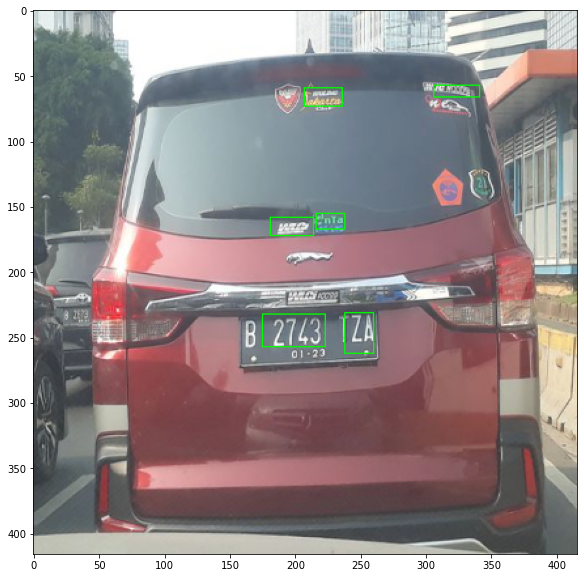

In [54]:
boxes = decode_predictions(outs)
for box in boxes:
    x, y, w, h = box
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 1)
        
plt.figure(figsize=(10,10))
plt.imshow(img[:,:,::-1])

In [ ]:
import os 
dataset = "ocr_dataset/"

for folder in os.listdir(dataset):
    for filename in folder : 
        src = cv2.imread("cars_1/plat-nomor-1.jpg")
        inpWidth = 20      
        inpHeight = 20     
        img = cv2.resize(src, (inpHeight, inpWidth))

        blob = cv2.dnn.blobFromImage(img, 1.0, (inpWidth, inpHeight), (0, 0, 0), swapRB=True, crop=False)

        east_model = "tensorflow/plate_number_ocr.pb"
        net = cv2.dnn.readNet(east_model)

        net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

        layerOutput = net.getUnconnectedOutLayersNames()

        net.setInput(blob)
        outs = net.forward(layerOutput)

### OCR with Tesseract
- Tesseract was originally developed at Hewlett-Packard Laboratories between 1985 and 1994. 
- In 2005, it was open-sourced by HP. -wikipedia-
- In 2006, Tesseract was considered one of the most accurate open-source OCR engines then available.
- Further development in tesseract has been sponsored by Google since 2006.


### Prepare Tesseract
- Download & Install Tesseract Software from https://tesseract-ocr.github.io/tessdoc/Downloads
- Install library **pytesseract** in anaconda: <br>
    `conda install -c conda-forge pytesseract`

In [2]:
import pytesseract

- using `.image_to_string()` on tesseract, we can extract text from image, <br><br>
`configuration = ("--oem x --psm y")` <br>
`pytesseract.image_to_string(image, lang=None, config=configuration, nice=0, output_type='string', timeout=0)`<br><br>
- where `config` = "--oem 3 --psm 3" :
    - `oem` (OCR Engine modes):
        - 0    Legacy engine only.
        - 1    Neural nets LSTM engine only.
        - 2    Legacy + LSTM engines.
        - 3    Default, based on what is available.
    - `psm` (Page segmentation modes):
        - 0    Orientation and script detection (OSD) only.
        - 1    Automatic page segmentation with OSD.
        - 2    Automatic page segmentation, but no OSD, or OCR. (not implemented)
        - 3    Fully automatic page segmentation, but no OSD. (Default)
        - 4    Assume a single column of text of variable sizes.
        - 5    Assume a single uniform block of vertically aligned text.
        - 6    Assume a single uniform block of text.
        - 7    Treat the image as a single text line.
        - 8    Treat the image as a single word.
        - 9    Treat the image as a single word in a circle.
        - 10    Treat the image as a single character.
        - 11    Sparse text. Find as much text as possible in no particular order.
        - 12    Sparse text with OSD.
        - 13    Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.


This is a lot of 12 point text to test the
ocr code and see if it works on all types
of file format.

The quick brown dog jumped over the
lazy fox. The quick brown dog jumped
over the lazy fox. The quick brown dog
jumped over the lazy fox. The quick
brown dog jumped over the lazy fox.



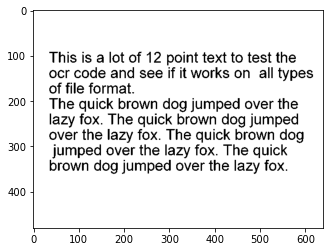

In [59]:
img = cv2.imread("image_text.jpg")

configuration = ("--oem 3 --psm 3")
text = pytesseract.image_to_string(img, config=configuration)

plt.imshow(img[:,:,::-1])
print(text)

- The capability of the Tesseract was mostly limited to structured text data. 
- It would perform quite poorly in **unstructured text** with significant noise. 

a



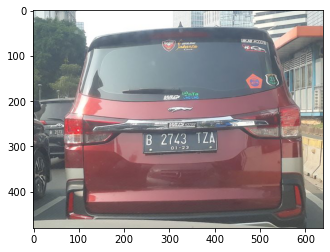

In [166]:
img = cv2.imread("plat-nomor-3.jpg")

configuration = ("--oem 1 --psm 8")
text = pytesseract.image_to_string(img, config=configuration)

plt.imshow(img[:,:,::-1])
print(text)

### Plate Number Recognition (Using EAST detect Plate Number Position)

In [3]:
import re

def clean_text(text):
    text = text.encode('ascii', errors="ignore").strip().decode("utf-8") 
    return re.sub('[^A-Za-z0-9]+', '', text)

In [4]:
def drawPred(frame, label, left, top, right, bottom):
    cv2.rectangle(frame, (left, top), (right, bottom), (255, 0, 255), 2)

    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), 
                         (max(right, left + labelSize[0]), top + baseLine), (255, 0, 255), -1)
    
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.50, (255, 255, 255), 1)
    return frame

In [7]:
src = cv2.imread("cars_2/mobil100.jpg")
inpWidth = 416      
inpHeight = 416     
img = cv2.resize(src, (inpHeight, inpWidth))

blob = cv2.dnn.blobFromImage(img, 1.0, (inpWidth, inpHeight), (0, 0, 0), swapRB=True, crop=False)

east_model = "tensorflow/frozen_east_text_detection.pb"
net = cv2.dnn.readNet(east_model)

net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

layerOutput = net.getUnconnectedOutLayersNames()

net.setInput(blob)
(geometry, scores) = net.forward(layerOutput)

geometry = np.array(geometry)
scores = np.array(scores)
outs = np.concatenate([geometry,scores], axis=1)

confThreshold = 0.5  
nmsThreshold = 0.4 

boxes = decode_predictions(outs)

h, w, c = img.shape
black = np.zeros((h, w)).astype(np.uint8)
for box in boxes:
    x, y, w, h = box
    cv2.rectangle(black, (x-15, y), (x + w, y+h), (255,255,255), -1)
    
black = cv2.resize(black, (src.shape[1], src.shape[0]))

contours, hierarchy = cv2.findContours(black, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
for i, cnt in enumerate(contours):
    x, y, w, h = cv2.boundingRect(cnt)
    if w > h :
        roi = src[y:y+h, x:x+w]
        
        r = 40/roi.shape[0]
        roi = cv2.resize(roi, (0,0), fx=r, fy=r)
        configuration = ("--oem 1 --psm 7")
        plate_text = pytesseract.image_to_string(roi, config=configuration)
        plate_text = clean_text(plate_text)
        print(plate_text)
        
        left = x
        top = y
        right = x+w
        bottom = y+h
        src = drawPred(src, plate_text, left, top, right, bottom)   
        cv2.imshow("plate img-%d" % i, roi)
    
cv2.imshow("car img", src)
cv2.waitKey(0)
cv2.destroyAllWindows()

1138KKM


### Plate Number Recognition (Using Find Contour to detect Plate Number Position)

In [8]:
def preprocessing(img, h1, h2):
    # get roi & resize 
    h, w, c = img.shape
    y1, y2, x1, x2 = int(h1), int(h2), int(w*0.30), int(w*0.70)
    roi = img[y1:y2, x1:x2]
    scale = 300/roi.shape[0]
    roi = cv2.resize(roi, (0,0), fx=scale, fy=scale)
    
    #convert to gray -> binary
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    __, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh, roi, [x1, y1, x2, y2], scale
    
def get_contours(thresh):
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    h, w, c = img.shape
    size = h*w
    contours = [cc for i, cc in enumerate(contours) if contour_char_OK(cc, size)]
    return contours

def contour_char_OK(cc, size=1000000):
    x, y, w, h = cv2.boundingRect(cc)
    area = cv2.contourArea(cc)
    
    if w < 3 or h < 5 or area < 80: 
        return False
    
    validDimentson = w/h > 0.11 and w/h < 0.7
    varidAreaRatio = area/(w*h)  > 0.2
    return validDimentson and varidAreaRatio

def sort_contours(contours, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(cnt) for cnt in contours]
    
    cnts, boundingBoxes = zip(*sorted(zip(contours, boundingBoxes), key=lambda b:b[1][i], reverse=reverse))
    return cnts, boundingBoxes

In [9]:
def crop_plate(thresh, contours):
    rects = []
    for i, cnt in enumerate(contours) :
        rect = cv2.boundingRect(cnt)
        rects.append(rect)

    rects = np.array(rects)

    if len(rects) < 4 :
        return False, thresh, []
    rects = similar_rect(rects, row=3, n=2) #similar rect for closest `h` (row 3)

    if len(rects) < 4 :
        return False, thresh, []
    rects = similar_rect(rects, row=2, n=2) #similar rect for closest `w` (row 2)

    if len(rects) < 4 :
        return False, thresh, []
    x1 = rects[:, 0].min()
    x2 = rects[:, 0].max() + rects[:, 2].max()
    y1 = rects[:, 1].min()
    y2 = rects[:, 1].max() + rects[:, 3].max()
    plate_number = thresh[y1:y2, x1:x2]
    return True, plate_number, [x1, y1, x2, y2]

def similar_rect(rects, row=3, n=2):
    mean = np.mean(rects[:, row])
    std = np.std(rects[:, row])
    rects = np.array([rect for rect in rects if abs(rect[row] - mean) < n*std and rect_ok(rect)])
    return rects

def rect_ok(rect):
    x, y, w, h = rect
    return w/h > 0.11 and w/h < 0.7

In [14]:
img = cv2.imread("cars_1/plat-nomor-3.jpg")

h, w, c = img.shape
thresh, roi, roi_rect, s = preprocessing(img, h1=0.5*h, h2=0.85*h )

contours = get_contours(thresh)
is_plate, plate_img, plate_rect = crop_plate(thresh, contours)

if is_plate :
    x1, y1, x2, y2 = plate_rect
    configuration = ("--oem 1 --psm 7")
    plate_text = pytesseract.image_to_string(roi[y1:y2, x1:x2], config=configuration)

    x1_, y1_, x2_, y2_ = roi_rect
    left = int(x1/s) + x1_
    top = int(y1/s) + y1_
    right = int(x2/s) + x1_
    bottom = int(y2/s) + y1_
    img = drawPred(img, plate_text.strip(), left, top, right, bottom)
    
cv2.imshow("plate img", roi[y1:y2, x1:x2])
cv2.imshow("car img", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

___
___
___
### Check for all image car (Find Contour Method)

In [17]:
import os 

dataset = 'cars_2/'
for filename in os.listdir(dataset):
    print(dataset + filename)
    img = cv2.imread(dataset + filename)

    h, w, c = img.shape
    thresh, roi, roi_rect, s = preprocessing(img, h1=0.5*h, h2=0.85*h )

    contours = get_contours(thresh)
    is_plate, plate_img, plate_rect = crop_plate(thresh, contours)

    if is_plate :
        x1, y1, x2, y2 = plate_rect
        configuration = ("--oem 1 --psm 7")
        plate_text = pytesseract.image_to_string(roi[y1:y2, x1:x2], config=configuration)

        x1_, y1_, x2_, y2_ = roi_rect
        left = int(x1/s) + x1_
        top = int(y1/s) + y1_
        right = int(x2/s) + x1_
        bottom = int(y2/s) + y1_
        img = drawPred(img, plate_text.strip(), left, top, right, bottom)

    cv2.imshow("plate img", roi[y1:y2, x1:x2])
    cv2.imshow("car img", img)
    cv2.waitKey(1000)
cv2.destroyAllWindows()

cars_2/mobil1.jpg
cars_2/mobil10.jpg
cars_2/mobil100.jpg
cars_2/mobil11.jpg
cars_2/mobil12.jpg
cars_2/mobil13.jpg
cars_2/mobil14.jpg
cars_2/mobil15.jpg
cars_2/mobil16.jpg
cars_2/mobil17.jpg
cars_2/mobil18.jpg
cars_2/mobil19.jpg
cars_2/mobil2.jpg
cars_2/mobil20.jpg
cars_2/mobil21.jpg
cars_2/mobil22.jpg
cars_2/mobil23.jpg
cars_2/mobil24.jpg
cars_2/mobil25.jpg
cars_2/mobil26.jpg
cars_2/mobil27.jpg
cars_2/mobil28.jpg
cars_2/mobil29.jpg
cars_2/mobil3.jpg
cars_2/mobil30.jpg
cars_2/mobil31.jpg
cars_2/mobil32.jpg
cars_2/mobil33.jpg
cars_2/mobil34.jpg
cars_2/mobil35.jpg
cars_2/mobil36.jpg
cars_2/mobil37.jpg
cars_2/mobil38.jpg
cars_2/mobil39.jpg
cars_2/mobil4.jpg
cars_2/mobil40.jpg
cars_2/mobil41.jpg
cars_2/mobil42.jpg
cars_2/mobil43.jpg
cars_2/mobil44.jpg
cars_2/mobil45.jpg
cars_2/mobil46.jpg
cars_2/mobil47.jpg
cars_2/mobil48.jpg
cars_2/mobil49.jpg
cars_2/mobil5.jpg
cars_2/mobil50.jpg
cars_2/mobil51.jpg
cars_2/mobil52.jpg
cars_2/mobil53.jpg
cars_2/mobil54.jpg
cars_2/mobil55.jpg
cars_2/mobil56.j

___
### Check for all image car (EAST DNN Method)

In [368]:
east_model = "frozen_east_text_detection.pb"
net = cv2.dnn.readNet(east_model)

net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

layerOutput = net.getUnconnectedOutLayersNames()

dataset = "cars_2/"
for filename in os.listdir(dataset):
    src = cv2.imread(dataset + filename)
    inpWidth = 416      
    inpHeight = 416     
    img = cv2.resize(src, (inpHeight, inpWidth))

    blob = cv2.dnn.blobFromImage(img, 1.0, (inpWidth, inpHeight), (0, 0, 0), swapRB=True, crop=False)

    net.setInput(blob)
    (geometry, scores) = net.forward(layerOutput)

    geometry = np.array(geometry)
    scores = np.array(scores)
    outs = np.concatenate([geometry,scores], axis=1)

    confThreshold = 0.5  
    nmsThreshold = 0.4 

    boxes = decode_predictions(outs)

    h, w, c = img.shape
    black = np.zeros((h, w)).astype(np.uint8)
    for box in boxes:
        x, y, w, h = box
        cv2.rectangle(black, (x-15, y), (x + w, y+h), (255,255,255), -1)

    black = cv2.resize(black, (src.shape[1], src.shape[0]))

    contours, hierarchy = cv2.findContours(black, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for i, cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)
        if w * 1.2 > h :
            roi = src[y:y+h, x:x+w]

            r = 40/roi.shape[0]
            roi = cv2.resize(roi, (0,0), fx=r, fy=r)
            configuration = ("--oem 1 --psm 7")
            plate_text = pytesseract.image_to_string(roi, config=configuration)
            plate_text = clean_text(plate_text)

            left = x
            top = y
            right = x+w
            bottom = y+h
            src = drawPred(src, plate_text, left, top, right, bottom)   

    cv2.imshow("car img", src)
    if cv2.waitKey(1000) == ord('q'):
        break
cv2.destroyAllWindows()

___
### Check for all image car (Yolo DNN Method)

In [19]:
def drawPred(label, left, top, right, bottom):
    cv2.rectangle(frame, (left, top), (right, bottom), (255, 0, 255), 2)

    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (max(right, left + labelSize[0]), top + baseLine), (255, 0, 255), -1)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.50, (255, 255, 255), 1)

def postprocess(frame, outs):
    frame_h, frame_w, frame_c = frame.shape
    classIds = []
    confidences = []
    boxes = []
    
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:        
                scores = detection[5:]
                classId = np.argmax(scores)
                confidence = scores[classId]
                c_x = int(detection[0] * frame_w)
                c_y = int(detection[1] * frame_h)
                w = int(detection[2] * frame_w)
                h = int(detection[3] * frame_h)
                x = int(c_x - w / 2)
                y = int(c_y - h / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])

    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    final_boxes = []
    for i in indices:
        i = i[0]
        final_boxes.append(boxes[i])
    return final_boxes


In [20]:
classesFile = "yolo/plate_number/plate_number.names"

classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')
    
modelConfiguration = "yolo/plate_number/plate_number_yolov3.cfg"
modelWeights = "yolo/plate_number/plate_number_yolov3.weights"

net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

layerOutput = net.getUnconnectedOutLayersNames()

confThreshold = 0.5  
nmsThreshold = 0.4 

inpWidth = 416      
inpHeight = 416     

In [21]:
import os
dataset = "cars_2/"
for filename in os.listdir(dataset):
    if filename.find(".jpg") < 0:
        continue
    
    frame = cv2.imread(dataset + filename)
    blob = cv2.dnn.blobFromImage(
        frame, 1/255, (inpWidth, inpHeight), [0, 0, 0], 1, crop=False)

    net.setInput(blob)
    outs = net.forward(layerOutput)

    boxes = postprocess(frame, outs)
    for box in boxes :
        x, y, w, h = box
        
        roi = frame[y:y+h, x:x+w]
        ratio = 40/roi.shape[0]
        roi = cv2.resize(roi, (0,0), fx=ratio, fy=ratio, interpolation = cv2.INTER_CUBIC)
        
        configuration = ("--oem 3 --psm 6")
        plate_text = pytesseract.image_to_string(roi, config=configuration)
        plate_text = clean_text(plate_text)
        
        drawPred(plate_text, x, y, x + w, y + h)
        print(plate_text, roi.shape)
        cv2.imshow("roi", roi)
    
    cv2.imshow("out", frame)
    if cv2.waitKey(3000) == ord('q'):
        break
        
cv2.destroyAllWindows()

TKN (40, 97, 3)
Cami (40, 111, 3)
B1138KKM (40, 140, 3)
Eo (40, 142, 3)
RS (40, 122, 3)
 (40, 68, 3)
a (40, 131, 3)
Wa (40, 126, 3)
 (40, 133, 3)
B1533PAE (40, 124, 3)
Para (40, 118, 3)
 (40, 75, 3)
oenmmeLTS186Sst (40, 102, 3)
CRESS (40, 110, 3)
B1388SSW (40, 128, 3)
 (40, 122, 3)
CPAyaNs (40, 118, 3)
me (40, 66, 3)
ERRNO (40, 125, 3)
eTrear (40, 73, 3)
B72329SIC (40, 133, 3)
 (40, 98, 3)
iyae7 (40, 99, 3)
1B1630SO (40, 103, 3)
aroe (40, 74, 3)
 (40, 103, 3)
B1247UIM (40, 100, 3)
 (40, 90, 3)
 (40, 80, 3)
Caryare (40, 122, 3)
1076Uae (40, 77, 3)
Te (40, 116, 3)
yarn (40, 131, 3)
iraneas (40, 72, 3)
 (40, 59, 3)
eeTae (40, 87, 3)
 (40, 59, 3)
at (40, 45, 3)
Lay (40, 57, 3)
A (40, 62, 3)
aig (40, 116, 3)
 (40, 91, 3)
B1802TNP (40, 141, 3)
Won (40, 110, 3)
meyeroeoy (40, 94, 3)
eees (40, 75, 3)
le (40, 59, 3)
oy (40, 40, 3)
everne (40, 121, 3)
B2212UKA (40, 115, 3)
PINa (40, 141, 3)
EES (40, 107, 3)
MARSH (40, 120, 3)
Caras (40, 115, 3)
li (40, 70, 3)
aml (40, 95, 3)
LOYAET (40, 124, 3)


# Limitations and Drawbacks
- It’s important to understand that no OCR system is perfect!
- There is no such thing as a perfect OCR engine, especially in real-world conditions.
- And furthermore, expecting 100% accurate Optical Character Recognition is simply unrealistic.
- As we found out, our OpenCV OCR system worked in well in some images, it failed in others.
- There are two primary reasons we will see our text recognition pipeline fail:
    - The text is skewed/rotated.
    - The font of the text itself is not similar to what the Tesseract model was trained on.

# Source 
- https://www.pyimagesearch.com/2018/09/17/opencv-ocr-and-text-recognition-with-tesseract/